In [ ]:
using Pkg
Pkg.activate("NB05")
Pkg.update()

In [2]:
using StatsBase, Plots, ReadableRegex

# Sprachmodelle

In diesen Notebook wollen wir drei simple Sprachmodelle ausprobieren.

* Zufällige Wortfolgen
* Das Uni-Gram Modell
* Das Bi-Gram Modell

Gegeben ein Wort $x$ generieren diese Modelle ein nächstes Wort $y$ gemäß eines statistischen Modells 

$$P(y\mid x).$$

Wir laden dazu einen Text-Corpus. Die drei Modelle $P(y\mid x)$  sind dann wie folgt definiert:


* Zufällige Wortfolgen: $P(y\mid x) = \frac{1}{N}$, wobei $N$ die Anzahl der vorkommenden Worte ist.
* Das Uni-Gram Modell: $P(y\mid x) = \frac{m}{n}$, wobei $m$ die Anzahl ist, wie oft $y$ im Text vorkommt, und $n$ die Gesamtzahl der Worte im Corpus.
* Das Bi-Gram Modell: $P(y\mid x) = \frac{a}{b}$, wobei $a$ die Anzahl ist, wie oft $y$ nach $x$ kommt, und $b$ die Anzahl, wie oft $x$ im Corpus vorkommt.

## Vorbereitung der Daten

Wir laden einen von zwei Datensätzen:

1. `shakespeare` enthält die gesammelten Werke von Shakespeare. Die Daten sind vom Projekt Gutenberg:

        https://www.projekt-gutenberg.org/autoren/namen/shakespr.html
2. `spongebob` enthält die Transkripte aus 393 Spongebob Episoden. Die Daten sind von Kaggle:

        https://www.kaggle.com/datasets/mikhailgaerlan/spongebob-squarepants-completed-transcripts

In [3]:
ordner = "../text/shakespeare"
#ordner = "../text/spongebob"

"../text/shakespeare"

Die nächste Zelle lädt den Text in die aktuelle Session. Am Ende ist `corpus` ein `String`, der den Text enhält.

In [4]:
##### Laden der Textdaten
R = readdir(ordner)
data = map(R) do filename
    filepath = join([ordner, "/", filename])
    open(filepath) do file
        read(file, String)
    end
end;
corpus = "";
for j = 1:length(data)
    corpus = join([corpus, data[j]])
end;

Wir schauen, wieviele zeichen `Corpus` enthält:

In [5]:
length(corpus)

5315523

Hier sind die ersten Einträge von `Corpus`:

In [6]:
corpus[1:600] |> print

THE SONNETS
                    1
From fairest creatures we desire increase,
That thereby beauty’s rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed’st thy light’s flame with self-substantial fuel,
Making a famine where abundance lies,
Thyself thy foe, to thy sweet self too cruel:
Thou that art now the world’s fresh ornament,
And only herald to the gaudy spring,
Within thine own bud buriest thy content,
And, tender churl, mak’st waste in niggarding:
  Pity the world, or else this gl

Um die Modelle zu berechnen, müssen wir zunächst Statistiken über die Häufigkeiten der Worte im Text berechnen.

Dazu splitten wir den Text in einzelne Worte.

Die Folgende Funktion benutzt `ReadableRegex` um auch Zeilenumbruche als Worte behandeln zu können.

In [7]:
function split_text(string)
    r = Regex(
        either(
            look_for("", before = "\n"),
            look_for("", after = "\n"),
        )
    )
    text_parts = split(string, r)
    words = map(text_parts) do part 
        text = split(part, " ")
    end
    vcat(words...)
end

split_text (generic function with 1 method)

Jetzt können wir den Textcorpus in die einzelnen Wörter zerlegen:

In [8]:
words = split_text(corpus);

Insgesamt haben wir nun den Text in die folgende Anzahl von Wörtern zerlegt:

In [9]:
length(words)

1136090

Die ersten Wörter in `words` sind:

In [10]:
for w in words[1:20]
    print(w, " ")
end

THE SONNETS 
                  

## Wort Statistiken

Wir haben den Textcorpus in einzelne Worte zerlegt.

Jetzt erstellen wir Statistiken darüber, welche Wörter wie oft vorkommen.

Dazu benutzen wir `countmap`:

In [11]:
stats = countmap(words)

Dict{SubString{String}, Int64} with 71166 entries:
  "ungoverned"    => 2
  "neighbours."   => 8
  "Proves"        => 1
  "Englishman;"   => 1
  "alms;"         => 1
  "Dries"         => 1
  "pre-contract." => 1
  "entomb"        => 2
  "greatness’"    => 1
  "redresses"     => 1
  "does;"         => 3
  "gathered"      => 6
  "graces;"       => 2
  "little,"       => 35
  "green-sward."  => 1
  "hangman?"      => 1
  "rubb’d"        => 2
  "feel;"         => 1
  "Apemantus,"    => 6
  "thus:"         => 34
  "DEIPHOBUS"     => 1
  "Castile,"      => 1
  "112"           => 2
  "proportioned"  => 1
  "revels;"       => 3
  ⋮               => ⋮

Die einzelnen Wörter auf der linken Seite von `stats` bilden das Vokabular.

Im Vokabular kommt jedes Wort genau einmal vor.

In [12]:
vocabulary = string.(keys(stats));

Wir vergleichen die Anzahl der Wörter im Text und im Vokabular

In [13]:
length(words), length(vocabulary)

(1136090, 71166)

und schauen uns die Häufigkeiten der ersten Worte im Text an:

In [14]:
for w in words[1:10]
     println([w], " kommt ", stats[w], " mal vor.")
end

SubString{String}["THE"] kommt 60 mal vor.
SubString{String}["SONNETS"] kommt 1 mal vor.
SubString{String}["\n"] kommt 153575 mal vor.
SubString{String}[""] kommt 19275 mal vor.
SubString{String}[""] kommt 19275 mal vor.
SubString{String}[""] kommt 19275 mal vor.
SubString{String}[""] kommt 19275 mal vor.
SubString{String}[""] kommt 19275 mal vor.
SubString{String}[""] kommt 19275 mal vor.
SubString{String}[""] kommt 19275 mal vor.


Als Nächstes analysieren wir die Worte, die am häufigsten vorkommen. 

Dazu müssen wir `counts` (die rechte Seite in `stats`) nach der Größe sortieren.

In [15]:
counts = collect(values(stats))
freq = sortperm(counts; rev = true);

Nun können wir die häufigsten Wörter anzeigen lassen:

In [16]:
m = 12
frequent_words = vocabulary[freq[1:m]];
println("Die $m häufigsten Wörter:\n")
for w in frequent_words
    println([w])
end

Die 12 häufigsten Wörter:

["\n"]
["the"]
["I"]
["and"]
[""]
["to"]
["of"]
["a"]
["my"]
["in"]
["you"]
["is"]


und auch ein Histogramm erstellen

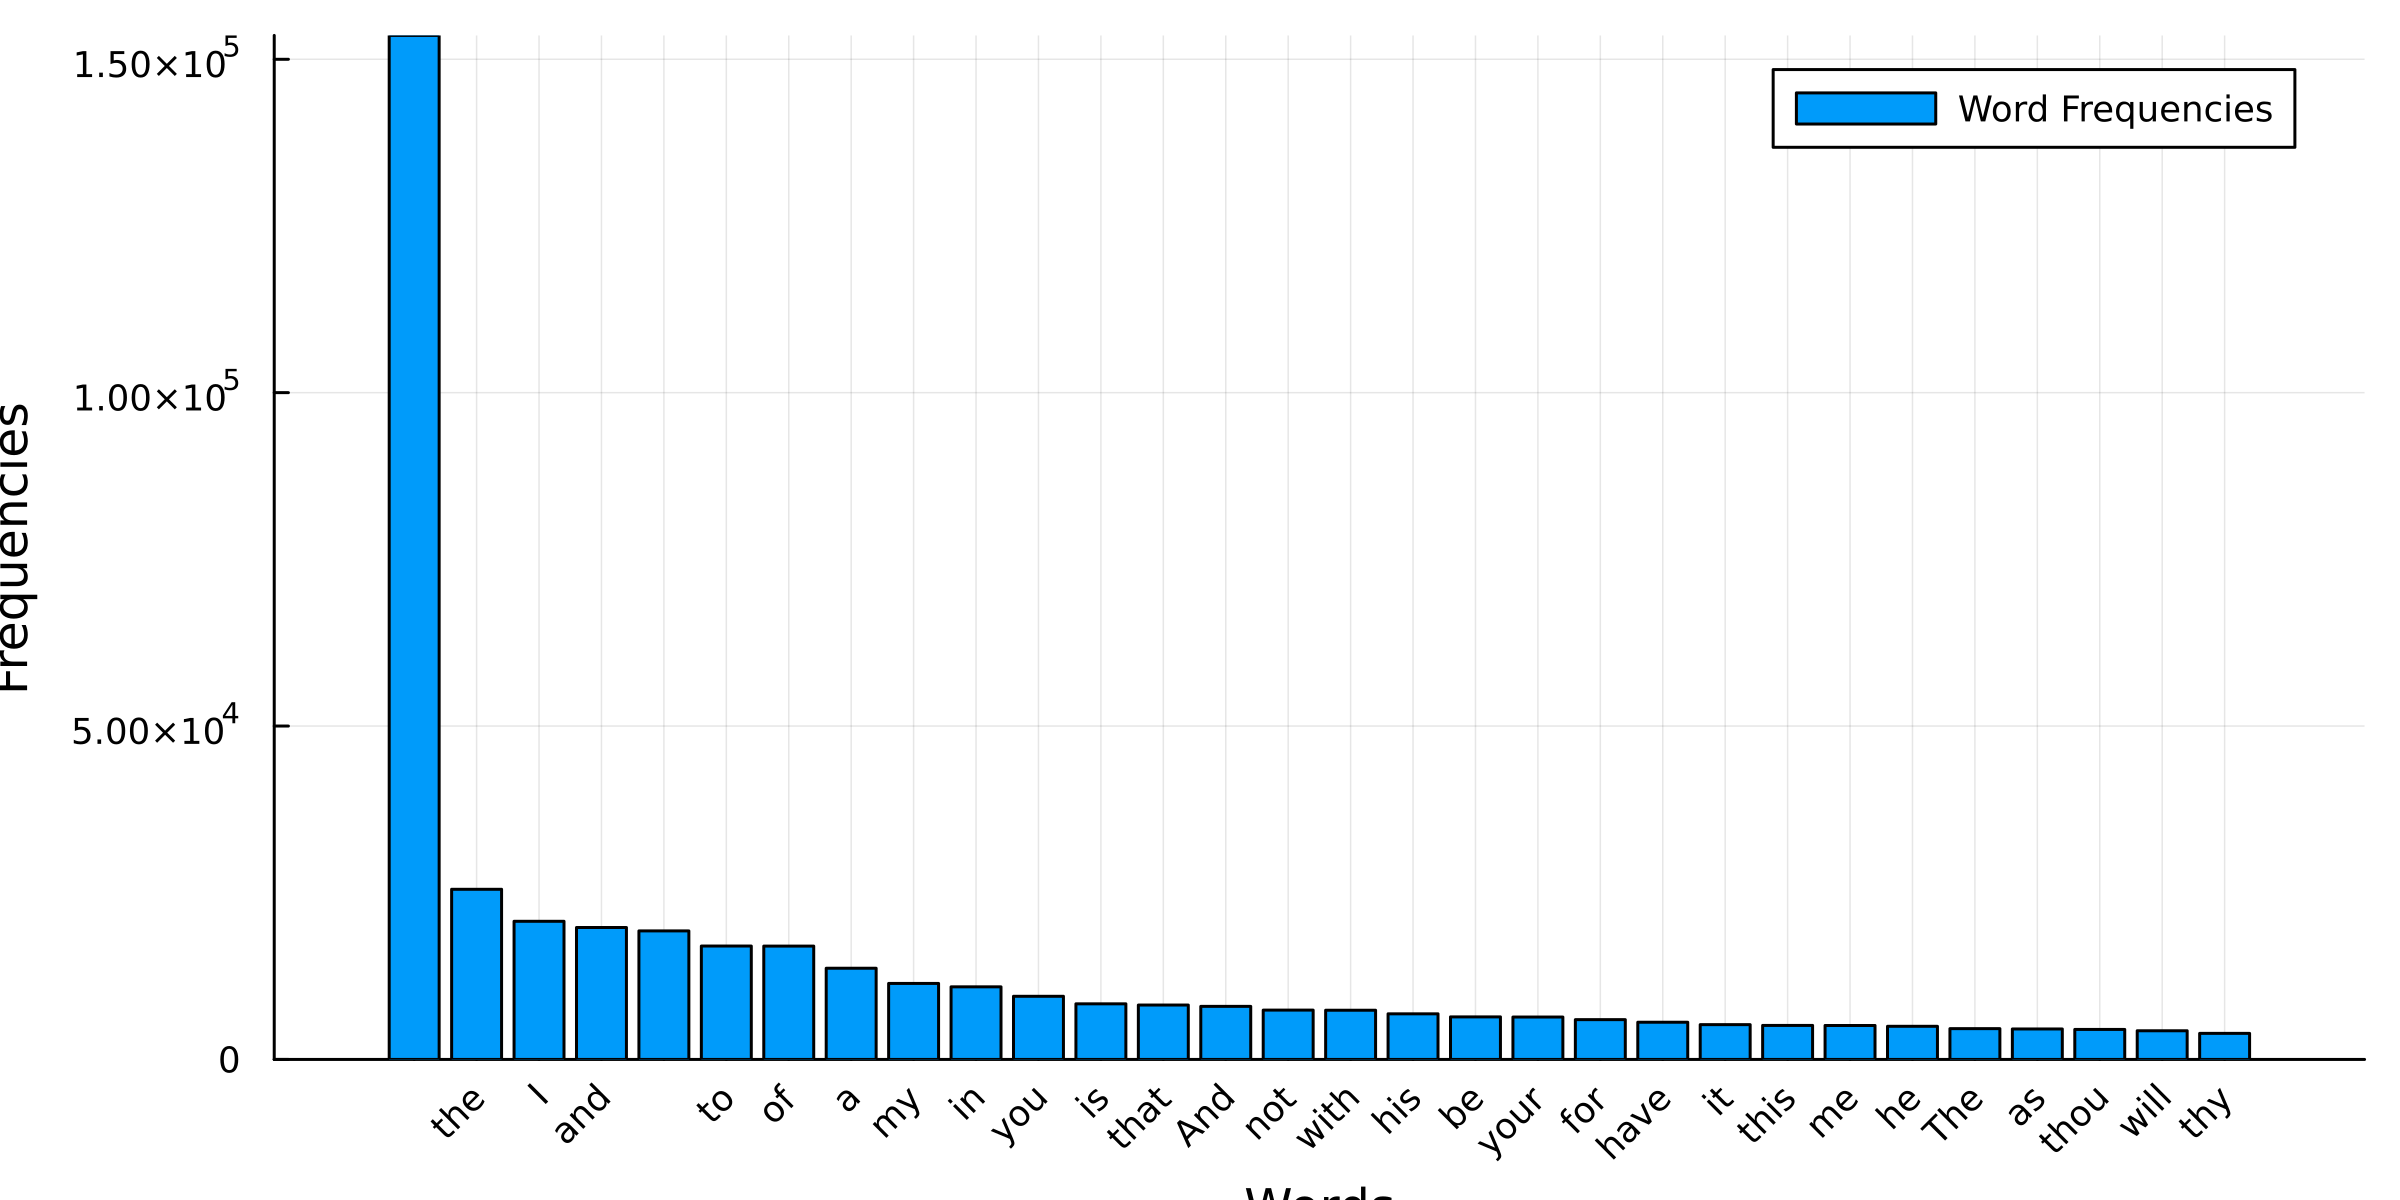

In [17]:
r = 1:30
plot(
     counts[freq[r]],
     seriestype = :bar,
     xticks = (r, vocabulary[freq[r]]),
     xrotation = 45,
     label = "Word Frequencies",
     xlabel = "Words",
     ylabel = "Frequencies",
     size = (800, 400),
     dpi = 300
 )

## Zufällige Wortfolgen

Nun implementieren wir das erste Modell, in dem Wörter zufällig aus dem Vokabular generiert werden.

In [18]:
function generate(word, n)
    text = join([word, " "])
    for i in 1:n-1
        w = rand(vocabulary)
        text = join([text, w, " "])
    end
    w = rand(vocabulary)
    text = join([text, w, "."])
    text
end

generate (generic function with 1 method)

Nun generieren wir einen Text mit dem ersten Wort `SpongeBob`.

In [19]:
text = generate("Son", 50)
print("\n\n", text, "\n\n")



Son ripe—what ordering; parler. Antonio? flashes Laughest 1164 peaten Note harmony. valour, mask’d: seat’s George; Will’d mum, become. eye-sore felon empery. Leicester library briars, alderliefest reneges PAINTER pride. hark!_ travails pineth helping meilleur squints cudgell’d. preambulate. Re-speaking Bedabbled primer skyey wrongs?—Daughter, fancy-monger, anchors, Coz, SERVANT, Loaden pause. maids: reprehends Tybalts. collect.



Wie man sieht, ist der generierte Text sehr unstrukturiert. 

Die nächsten Modelle generieren strukturierteren Text.

## Uni-Gram

Als Nächstes implementieren wir das Uni-Gram Modell, in dem Wörter nach der Häufigkeit, wie sie im Textcorpus vorkommen, generiert werden. 

Die Häufigkeiten haben wir zuvor in `counts` gespeichert.

In [20]:
sample_word() = sample(vocabulary, FrequencyWeights(counts))
function unigram(word, n)
    text = join([word, " "])
    for i in 1:n-1
        w = sample_word()
        text = join([text, w, " "])
    end
    w = sample_word()
    text = join([text, w, "."])
    text
end

unigram (generic function with 1 method)

Das Modell generiert Worte gemäß des folgenden Wortgenerators:

In [21]:
sample_word()

"my"

Nun generieren wir einen Text mit dem ersten Wort `SpongeBob`.

In [22]:
text = unigram("thou", 50)
print("\n\n", text, "\n\n")



thou my Fie than tongue filled, 
 
 the as To sun, 
 Hall sight: 
 II. be on hence lives then France, thy the Amazons, “Thou, good his 
 of proud, Montague where 
 
 shall did have to Like 
 not it up fortune, beauty France. shallowest say vile,.



Wie man sieht, hat der Text schon etwas mehr Struktur, als das einfachere Modell mit zufälligen Wortfolgen.

## Bi-Gram

Als Letztens implementieren wir das Bi-Gram Modell. 

Gegeben ein Wort $x$, generiert dieses Modell ein nächstes Wort $y$ gemäß der relativen Häufigkeit, wie oft $y$ nach $x$ im Text vorkommt.

In [23]:
function sample_word(word)
    idx = findall(words .== word) .+ 1
    filter!(i -> i <= length(words), idx)
    local_stats = countmap(words[idx]);
    local_vocabulary = words[idx]
    local_counts = map(w -> local_stats[w], local_vocabulary)
    next = sample(local_vocabulary, FrequencyWeights(local_counts))
    next
end
function bigram(word, n)
    text = join([word, " "])
    w = word
    for i in 1:n-1
        w = sample_word(w)
        text = join([text, w, " "])
    end
    w = sample_word(w)
    text = join([text, w, "."])
    text
end

bigram (generic function with 1 method)

Das Modell generiert Worte gemäß des folgenden Wortgenerators:

In [24]:
sample_word("We")

"have"

Wir generieren wieder einen Text mit dem ersten Wort `SpongeBob`.

In [25]:
text = bigram("anger", 100)
print("\n\n", text, "\n\n")



anger thrusts into the very good Lord of the 
 And you with a man of my good a good to be 
 Enter Theseus, Hippolyta, Emilia, 
 If this is the world of this is your own 
 Now, Bagot, and the 
 But I have a little to the 
 That I am a jewel in the mercer, for thy 
 The same. A street 
                                 .

